In [1]:

"""
Figures & tables for results of rooftop mapping in Washington D.C. and Denver, Colorado

Main text: 
Figure 1. Study area map, roof materials distribution, and building footprint area.
Figure 2. Example image chunks from satellite imagery for all classes 
    (see _plot-image-chunks-DC.ipynb)
Figure 3. CNN model loss function across folds for both regions.
Figure 4. Results from CV - model accuracy metrics.

Supplement:
Figure S1. Band correlations.
Figure S2. Spectral response for different materials.
Figure S3. Confusion matrices.
Figure S4. Results from tuning workflow.

Author: maxwell.cook@colorado.edu
"""

import os, sys, gc
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import numpy as np
import pyproj
import earthpy.plot as ep
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set some matplotlib settings
%matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

# environment
projdir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/'
proj = 32618  # UTM Zone 18N

print("Ready!")

Ready!


## Fig. 1: Study area map and distribution of training data

- 1a) Distribution of roof material classes
- 1b) Map of the study region
- 1c) Distribution of building sizes by roof material

In [2]:
# Load the footprint data for both ROIs

# Washington D.C.
fp = os.path.join(projdir, 'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
dc_ref = gpd.read_file(fp)
# Denver, Colorado
fp = os.path.join(projdir, 'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
denver_ref = gpd.read_file(fp)

# Create a dictionary for data access:
refs = {'DC': dc_ref, 'Denver': denver_ref}

dc_ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,1CS,CS,Composition Shingle,357.783709,5574.0,"POLYGON ((324215.868 4313568.665, 324215.792 4..."
1,3CS,CS,Composition Shingle,918.640862,1111.0,"POLYGON ((324602.816 4311717.247, 324604.322 4..."
2,9CS,CS,Composition Shingle,1383.414170,4222.0,"POLYGON ((327253.581 4300371.859, 327258.154 4..."
3,19CS,CS,Composition Shingle,836.410297,3450.0,"POLYGON ((333608.13 4306267.691, 333607.957 43..."
4,27CS,CS,Composition Shingle,330.514264,4352.0,"POLYGON ((326482.699 4300939.466, 326487.386 4..."


In [3]:
print(f"DC class distribution:\n{refs['DC']['class_code'].value_counts()}\n")
print(f"Denver class distribution: {refs['Denver']['class_code'].value_counts()}")

DC class distribution:
class_code
CS    37133
ME    36864
SL    15267
UR     1279
WS     1152
TL      924
SH      783
Name: count, dtype: int64

Denver class distribution: class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64


In [6]:
# get unique classes
all_classes = set()
for gdf in refs.values():
    all_classes.update(gdf['class_code'].unique())
print(all_classes)
# Create a color palette for roof materials
all_classes = sorted(all_classes)  # Sort for consistent ordering
class_palette = sns.color_palette('husl', len(all_classes))
color_mapping = dict(zip(all_classes, class_palette))
print(color_mapping)

{'CS', 'TL', 'SH', 'AP', 'TG', 'ME', 'CN', 'UR', 'WS', 'SL'}
{'AP': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701), 'CN': (0.8616090647292522, 0.536495730113334, 0.19548899031476086), 'CS': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337), 'ME': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499), 'SH': (0.20125317221201128, 0.6907920815379025, 0.47966761189275336), 'SL': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681), 'TG': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209), 'TL': (0.433280341176423, 0.6065273407962815, 0.9585467098271748), 'UR': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522), 'WS': (0.962272393509669, 0.3976451968965351, 0.8008274363432775)}


In [7]:
# create a hex code version too
hex_mapping = {key: "#{:02x}{:02x}{:02x}".format(
    int(r * 255), int(g * 255), int(b * 255)) 
    for key, (r, g, b) in color_mapping.items()
}
# Print the HEX color mapping
print(hex_mapping)

{'AP': '#f67088', 'CN': '#db8831', 'CS': '#ad9c31', 'ME': '#77aa31', 'SH': '#33b07a', 'SL': '#35aca4', 'TG': '#38a8c5', 'TL': '#6e9af4', 'UR': '#cc79f4', 'WS': '#f565cc'}


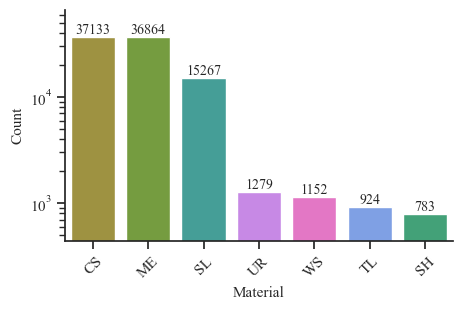

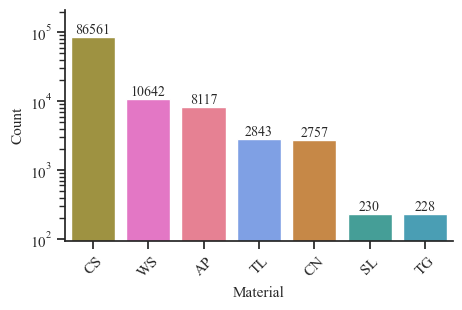

<Figure size 640x480 with 0 Axes>

In [8]:
# font = 'Arial'
font = 'Times New Roman'
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(style="ticks", rc={"font.family": "Times New Roman"})

for roi, ref in refs.items():
    ref = ref.sort_values(by='class_code')
    # Count the occurrences of each class_code
    class_counts = ref['class_code'].value_counts()
    class_counts = ref['class_code'].value_counts().reset_index()
    class_counts.columns = ['class_code', 'count']

    # IDentify the color palette for the region
    region_palette = [color_mapping[cls] for cls in class_counts['class_code']]

    # Plot the bar chart, assigning 'hue' to 'class_code'
    f, ax = plt.subplots(figsize=(5, 3))  
    sns.despine(f) # remove top and right borders
    
    ax = sns.barplot(
        x='class_code', y='count', data=class_counts, 
        hue='class_code', palette=region_palette, 
        dodge=False, legend=False
    )

    # Apply log scale to y-axis
    plt.yscale('log')

    # Add labels to each bar
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # X position of the label
            p.get_height(),                 # Y position of the label
            f'{int(p.get_height())}',       # Label text (the count)
            ha='center',                    # Horizontal alignment
            va='bottom',                    # Vertical alignment
            fontsize=10                     # Font size of the labels
        )

    # plt.title(f'{roi} Class Distribution')
    plt.xlabel('Material', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.xticks(rotation=45)

    ax.margins(y=0.15) # add some upper spacing

    # Save the figure
    out_png = os.path.join(projdir,f'figures/Figure1_{roi}_class_distribution.png')
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    
    plt.show()

plt.tight_layout()
plt.show()

In [ ]:
# Footprint area and dispersion metrics by class code
# Plot the distribution of building footprint area
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(style="ticks", rc={"font.family": "Times New Roman"})

# Loop through the dictionary to create separate histograms
for roi, ref in refs.items():
    ref = ref.sort_values(by='class_code')
    ref['areaUTMsqm'] = ref['areaUTMsqft'] * 0.092903
    
    # Create a figure and axis for each region
    f, ax = plt.subplots(figsize=(5, 3))   
    sns.despine(f) # remove top and right borders

    # Get the color palette
    unique_classes = ref['class_code'].unique()
    region_palette = {cls: color_mapping[cls] for cls in unique_classes if cls in color_mapping}
    
    # Plot the PDFs using kdeplot
    for cls in unique_classes:
        subset = ref[ref['class_code'] == cls]
        sns.kdeplot(
            data=subset,
            x="areaUTMsqm",
            bw_adjust=0.5,  # Adjust smoothing bandwidth if necessary
            log_scale=True,
            linewidth=1.2,
            label=cls,
            color=region_palette[cls]
        )

    # Calculate the overall mean of 'areaUTMsqft'
    area_mean = ref['areaUTMsqm'].mean() # in sqm
    # Add a vertical dotted line for the mean
    ax.axvline(area_mean, color='gray', linestyle='--', linewidth=1)

    # Add a text label for the mean
    ax.text(
        area_mean * 0.6, ax.get_ylim()[1] * 0.95,  # Shift left by multiplying x by 0.7
        f'Mean: {area_mean:.2f} sqm',
        color='gray',
        fontsize=10,
        ha='right',  # Align text to the right
        backgroundcolor='white'
    )
    
    # Set axis labels
    plt.xlabel('Building Area (sqm)', fontsize=11)
    plt.ylabel('Probability Density', fontsize=11)
    plt.xscale('log')
    
    # Dynamically adjust x-axis limits
    xmin, xmax = ref['areaUTMsqm'].min(), ref['areaUTMsqm'].max()
    plt.xlim(xmin * 0.9, xmax * 1.2)  # Extend limits slightly

    # Adjust y-axis limits for breathing room
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 1.1)

    # Add legend inside the plot (upper right)
    plt.legend(title="Material", loc="upper right", fontsize=9, frameon=True)
    
    # Save the figure
    out_png = os.path.join(projdir,f'figures/Figure1_{roi}_area_dist.png')
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

In [ ]:
# # option #2
# sns.boxplot(data=ref, x="class_code", y="areaUTMsqm", log_scale=True, palette=region_palette)
# # option #3
# sns.violinplot(
#     data=ref, y="class_code", x="areaUTMsqm", 
#     scale="width", inner=None, log_scale=True, palette=region_palette
# )

## Supplement

In [10]:
# Table S1. Microsoft Building Footprint area and distance distributions
# Calculate dispersion metrics for each region
from scipy.spatial import KDTree

knn_by_material = {}
for roi, ref in refs.items():
    knn_by_material[roi] = {}
    # Group the data by 'class_code'
    for class_code, group in ref.groupby('class_code'):
        # Generate the centroid for the group
        centroid = group.geometry.centroid
        # Grab the coordinate pairs
        coords = np.array([(geom.x, geom.y) for geom in centroid])
        # Proceed only if there are at least 2 points in the group
        if len(coords) > 1:
            # Set up the nearest neighbor search
            kdtree = KDTree(coords)
            distances, _ = kdtree.query(coords, k=2)  # k=2 because the nearest point is itself
            # Calculate the average distance to nearest neighbor for this class_code
            knn_by_material[roi][class_code] = distances[:, 1]
        else:
            knn_by_material[roi][class_code] = np.nan  # Handle cases where there are fewer than 2 points

# Create a dataframe from the results
knns = []
for roi, class_distances in knn_by_material.items():
    for class_code, distances in class_distances.items():
        for dist in distances:
            knns.append({'Region': roi, 'class_code': class_code, 'Distance': dist})
knn_df = pd.DataFrame(knns)
print(knn_df.head())

# Calculate mean nearest neighbor distance for each class_code and region
knn_df_mean = knn_df.groupby(['Region', 'class_code'])['Distance'].mean().reset_index()
# mean distance across all classes
print(f"\nAverage distance (all footprints):\n{knn_df_mean.groupby('Region')['Distance'].mean()}\n")

  Region class_code   Distance
0     DC         CS  10.082770
1     DC         CS   6.388587
2     DC         CS  11.458459
3     DC         CS   6.748317
4     DC         CS  10.524797

Average distance (all footprints):
Region
DC        34.556320
Denver    84.360794
Name: Distance, dtype: float64



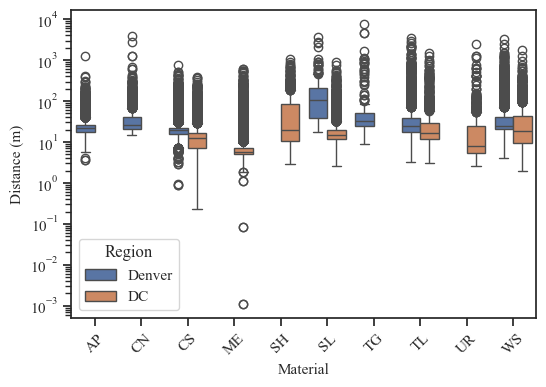

In [11]:
# Sort the class codes
knn_df = knn_df.sort_values(by='class_code', ascending=True).reset_index(drop=True)

# Set the plot
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_theme(style="ticks", rc={"font.family": "Times New Roman"})

f, ax = plt.subplots(figsize=(6, 4))

sns.boxplot(x='class_code', y='Distance', hue='Region', data=knn_df)
plt.yscale('log')
ax.set_xlabel('Material', fontsize=11)
ax.set_ylabel('Distance (m)', fontsize=11)
plt.xticks(rotation=45)

# Save the figure
out_png = os.path.join(projdir, f'figures/FigureX_dc-denver_footprints_knn.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [12]:
# Calculate the area metrics and combine with dispersion for supplement table
area_dist_stats = {}
for roi, ref in refs.items():
    # Calculate the area and side length statistics (see __functions.py)
    area_df = ref.groupby('class_code').apply(footprint_area_stats).reset_index()
    area_df['Region'] = roi # add the region as a column
    # Combine with the nearest neighbor distances
    area_dist_df = pd.merge(area_df, knn_df_mean, on=['Region', 'class_code'])
    area_dist_stats[roi] = area_dist_df

# Merge the two
area_dist_combined = pd.concat(area_dist_stats.values(), ignore_index=True)
area_dist_combined.head()
# Export as a CSV
out_csv = os.path.join(projdir, 'figures/SuppTable_footprint_area_distances.csv')
area_dist_combined.to_csv(out_csv)
print(f"\nSaved to: {out_csv}\n")

area_dist_stats['Denver'] # check the table result


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping/figures/SuppTable_footprint_area_distances.csv



,class_code,mean_area,pct90_area,mean_side_length,std_side_length,max_side_length,pct90_longest_side,Region,Distance
0,AP,220.275065,334.693436,15.382730,2.096756,139.575377,21.930919,Denver,26.629368
1,CN,379.317451,590.036484,21.179416,3.249251,86.199454,34.788889,Denver,44.489683
2,CS,173.869085,255.850890,13.564221,2.021024,137.451338,20.190204,Denver,20.549340
3,SL,542.682291,1027.882964,27.105747,5.348558,95.974952,54.098605,Denver,214.805496
4,TG,498.942272,824.956488,22.750724,6.634758,228.912855,49.078230,Denver,175.875115
5,TL,261.383820,440.409775,16.510694,2.280717,102.425388,26.692619,Denver,63.599779
6,WS,250.797337,393.927105,16.692925,2.598482,70.664955,27.524037,Denver,44.576780


In [13]:
gc.collect() # clear space

24273

### Classification results

In [49]:
# load the classification results
dc_fp = os.path.join(projdir, 'results/resnet18/classification/dc-resnet18-inference_ms-footprints_mean.gpkg')
denver_fp = os.path.join(projdir, 'results/resnet18/classification/denver-resnet18-inference_ms-footprints_mean.gpkg')
dc_cls = gpd.read_file(dc_fp) # read the dc geopackage
denver_cls = gpd.read_file(denver_fp)
# check the table
print(denver_cls.head())
# get some counts
print(f"\n\nLength of D.C. footprints all data: {len(dc_cls)}")
print(f"Length of Denver footprints all data: {len(denver_cls)}\n")

   uid prediction  confidence        TL        WS        CN        AP  \
0    1         TL    0.600086  0.318447  0.367123  0.050103  0.017146   
1    2         CN    0.506891  0.059596  0.242447  0.318632  0.030853   
2    3         CS    0.996183  0.000535  0.000808  0.000123  0.000160   
3    4         CS    0.999402  0.000131  0.000328  0.000021  0.000023   
4    5         CS    0.998353  0.000330  0.000572  0.000062  0.000167   

         SL        TG        CS  \
0  0.037375  0.012347  0.197460   
1  0.093931  0.011274  0.243266   
2  0.000094  0.002096  0.996183   
3  0.000017  0.000078  0.999402   
4  0.000047  0.000470  0.998353   

                                            geometry  
0  POLYGON ((508060.415 4398334.066, 508060.659 4...  
1  POLYGON ((508048.832 4395402.828, 508034.603 4...  
2  POLYGON ((508035.125 4408152.316, 508022.631 4...  
3  POLYGON ((508027.602 4409939.978, 508015.196 4...  
4  POLYGON ((508026.68 4409187.594, 508026.841 44...  


Length of D.C. foo

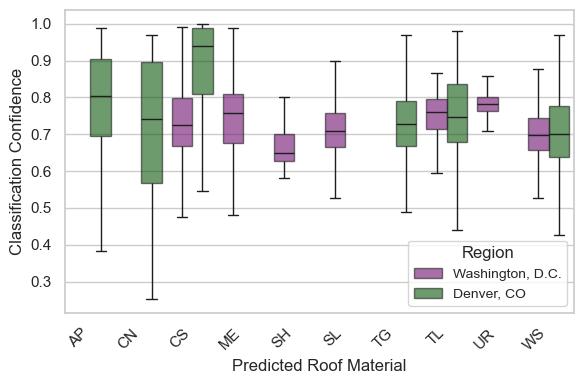

In [39]:
# boxplot of confidence by material class
# Add a region column to distinguish between the two AOIs
dc_cls["region"] = "Washington, D.C."
denver_cls["region"] = "Denver, CO"
# combine them
df1 = dc_cls.drop(columns=["geometry"])
df2 = denver_cls.drop(columns=["geometry"])
cls_df = pd.concat([df1, df2])
del df1, df2

# Sort by class for consistent ordering
cls_df["prediction"] = (
    pd.Categorical(
        cls_df["prediction"], 
        categories=sorted(cls_df["prediction"].unique()), 
        ordered=True
    )
)

# Set up the figure
plt.figure(figsize=(6, 4))
sns.set_theme(style="whitegrid")
# Define a color palette for the two regions
aoi_palette = {
    "Washington, D.C.": 'purple',
    "Denver, CO": 'darkgreen'
} 
# Create the stacked boxplot
ax = sns.boxplot(
    data=cls_df, x="prediction", y="confidence", hue="region",
    palette=aoi_palette, showfliers=False  # Hide outliers for clarity
)
# adjust the transparency
for patch in ax.patches:
    patch.set_alpha(0.6)
# Improve readability
plt.xlabel("Predicted Roof Material", fontsize=12)
plt.ylabel("Classification Confidence", fontsize=12)
plt.xticks(rotation=45, ha="right")
# Move the legend outside the plot
plt.legend(title="Region", loc="lower right", bbox_to_anchor=(1, 0), fontsize=10, frameon=True)
# Show the plot
plt.tight_layout()

# Save the figure
out_png = os.path.join(projdir, f'figures/FigureA3_dc-denver_classified_confidence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

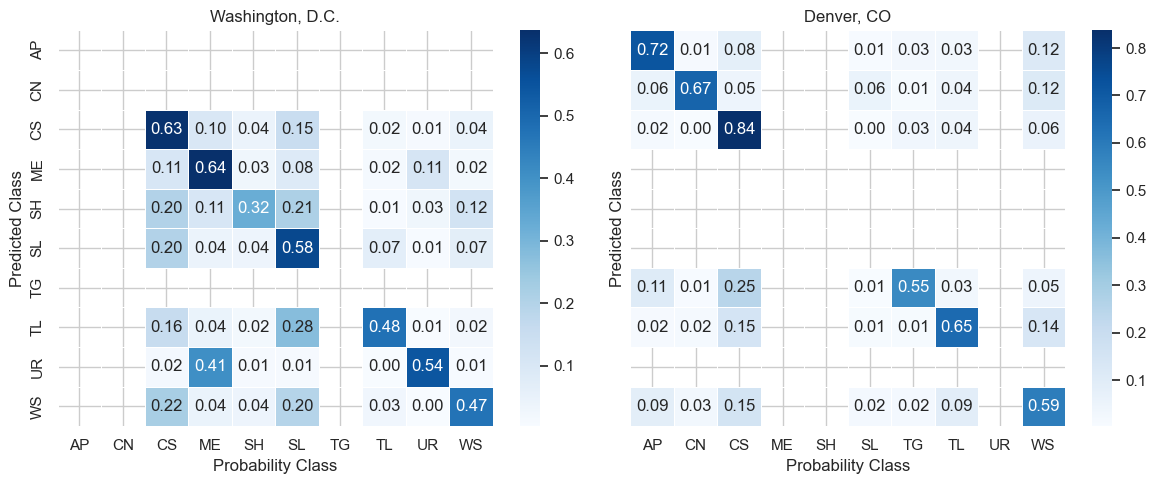

In [40]:
# Heatmap of prediction probabilities
df = cls_df.copy() # work with a copy
# Melt the dataset to long format for better aggregation
df_m = df.melt(
    id_vars=["prediction", "region"], 
    value_vars=[col for col in df.columns if col not in ["uid", "region", "confidence", "geometry"]]
)
# compute mean probability for each prediction-region-class combination
conf_mat = df_m.groupby(["prediction", "region", "variable"])["value"].mean().reset_index()

# get unique regions
regions = df["region"].unique()

# Create subplots for the two regions
fig, axes = plt.subplots(1, len(regions), figsize=(12, 5), sharex=True, sharey=True)
# loop through regions and create a heatmap for each
for ax, region in zip(axes, regions):
    # Subset data for the current region
    conf_mat_region = conf_mat[conf_mat["region"] == region]
    # Get unique classes for this region
    region_classes = sorted(set(conf_mat_region["prediction"]).union(set(conf_mat_region["variable"])))
    # Pivot to create confusion matrix
    conf_mat_p = conf_mat_region.pivot(index="prediction", columns="variable", values="value")
    # Ensure square matrix by reindexing
    conf_mat_p = conf_mat_p.reindex(index=region_classes, columns=region_classes, fill_value=0)
    # Plot heatmap
    sns.heatmap(conf_mat_p, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5, ax=ax)
    # Titles and labels
    ax.set_title(f"{region}")
    ax.set_xlabel("Probability Class")
    ax.set_ylabel("Predicted Class")

# Adjust layout and show
plt.tight_layout()

# Save the figure
out_png = os.path.join(projdir, f'figures/FigureA4_dc-denver_classified_conf_mat_probs.png')
plt.savefig(out_png, dpi=500, bbox_inches='tight')

plt.show()

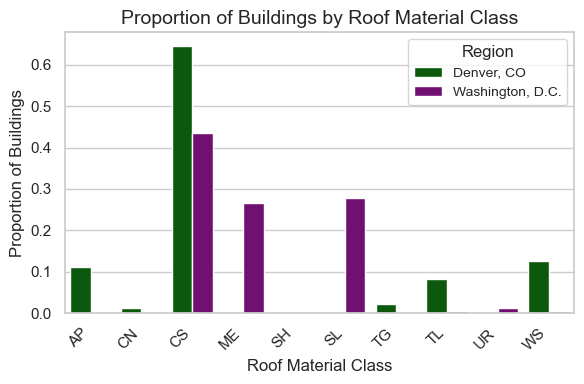

In [52]:
# Count the occurrences of each predicted class per region
class_counts = (
    cls_df.groupby("region")["prediction"]
    .value_counts(normalize=True).reset_index(name="proportion")
)

# Set up the figure
plt.figure(figsize=(6, 4))
sns.set_theme(style="whitegrid")
# Define colors matching previous plots
aoi_palette = {"Washington, D.C.": 'purple', "Denver, CO": 'darkgreen'}
# Create a grouped bar plot showing proportions
ax = sns.barplot(
    data=class_counts, x="prediction", y="proportion", hue="region",
    palette=aoi_palette
)

# Improve readability
plt.xlabel("Roof Material Class", fontsize=12)
plt.ylabel("Proportion of Buildings", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.title("Proportion of Buildings by Roof Material Class", fontsize=14)

# Move the legend inside the plot (bottom right)
plt.legend(title="Region", loc="upper right", fontsize=10, frameon=True)

# Show the plot
plt.tight_layout()
plt.show()

In [53]:
class_counts

,region,prediction,proportion
0,"Denver, CO",CS,0.646445
1,"Denver, CO",WS,0.125107
2,"Denver, CO",AP,0.112410
3,"Denver, CO",TL,0.082140
4,"Denver, CO",TG,0.022267
5,"Denver, CO",CN,0.011632
6,"Denver, CO",ME,0.000000
7,"Denver, CO",SH,0.000000
8,"Denver, CO",SL,0.000000
9,"Denver, CO",UR,0.000000


In [55]:
# Look at the distribution of classified types
# load the labeled data
dc_fp = os.path.join(projdir,'data/spatial/mod/dc_data/training/dc_data_reference_footprints.gpkg')
denver_fp = os.path.join(projdir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg')
dc_tr = gpd.read_file(dc_fp) # read the dc geopackage
denver_tr = gpd.read_file(denver_fp) # read denver training data
# check the table
print(denver_tr.head())
# get some counts
print(f"\n\nLength of D.C. footprints reference data: {len(dc_tr)}")
print(f"Length of Denver footprints reference data: {len(denver_tr)}\n")
print(f"\tProportion labeled: {len(denver_tr)/len(denver_cls)}")

     uid class_code description  areaUTMsqft  lotSizeSqft  \
0   78TL         TL        Tile   271.028875       4710.0   
1  269TL         TL        Tile  3885.053236      22307.0   
2  490TL         TL        Tile  2018.268605       6250.0   
3  497TL         TL        Tile   273.843801       6370.0   
4  537TL         TL        Tile   281.649002       6000.0   

                                            geometry  
0  MULTIPOLYGON (((502162.154 4397355.647, 502162...  
1  MULTIPOLYGON (((503091.622 4397021.987, 503101...  
2  MULTIPOLYGON (((501990.912 4396754.28, 502007....  
3  MULTIPOLYGON (((502773.275 4396965.742, 502773...  
4  MULTIPOLYGON (((502162.107 4396885.437, 502168...  


Length of D.C. footprints reference data: 93402
Length of Denver footprints reference data: 111378

	Proportion labeled: 0.2783093242044503


In [56]:
# merge and tidy the labeled training data
df1 = dc_tr.drop(columns=["geometry"])
df2 = denver_tr.drop(columns=["geometry"])
df1["region"] = "Washington, D.C."
df2["region"] = "Denver, CO"
tr_df = pd.concat([df1, df2])
train_counts = tr_df.groupby("region")["class_code"].value_counts(normalize=False).reset_index(name="true_prop")
train_counts.rename(columns={'class_code': 'true_class'}, inplace=True)
train_counts

,region,true_class,true_prop
0,"Denver, CO",CS,86561
1,"Denver, CO",WS,10642
2,"Denver, CO",AP,8117
3,"Denver, CO",TL,2843
4,"Denver, CO",CN,2757
5,"Denver, CO",SL,230
6,"Denver, CO",TG,228
7,"Washington, D.C.",CS,37133
8,"Washington, D.C.",ME,36864
9,"Washington, D.C.",SL,15267


In [45]:
# merge the predicted counts and training data
all_counts = pd.merge(
    train_counts, class_counts, 
    left_on=["region", "true_class"], 
    right_on=["region", "prediction"], 
    how="outer"
)
all_counts

,region,true_class,true_prop,prediction,proportion
0,"Denver, CO",AP,0.072878,AP,0.112410
1,"Denver, CO",CN,0.024754,CN,0.011632
2,"Denver, CO",CS,0.777182,CS,0.646445
3,"Denver, CO",NaN,NaN,ME,0.000000
4,"Denver, CO",NaN,NaN,SH,0.000000
5,"Denver, CO",SL,0.002065,SL,0.000000
6,"Denver, CO",TG,0.002047,TG,0.022267
7,"Denver, CO",TL,0.025526,TL,0.082140
8,"Denver, CO",NaN,NaN,UR,0.000000
9,"Denver, CO",WS,0.095548,WS,0.125107


In [ ]:
# load the accuracy reports.


In [ ]:
# Figure S1. Band correlation matrices
# load the DC stack
fp = os.path.join(projdir,'data/spatial/mod/dc_data/planet-data/dc_0623_psscene8b_stack.tif')
dc_stack = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto')
print(f"\n{dc_stack}")
# load the full stack
fp = os.path.join(projdir,'data/spatial/mod/denver_data/planet-data/denver_0815_psscene8b_stack.tif')
denver_stack = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto')
print(f"\n{denver_stack}")

In [ ]:
# check on one of the bands
ep.plot_bands(
    dc_stack[13].squeeze(),
    scale=False,
    vmin=-1,vmax=1,
    title="NISI",
    figsize=(6,6))

In [ ]:
# Get the correlation matrix
# see __functions.py
dc_cor_mat = band_correlations(dc_stack, plot=True) 
denver_cor_mat = band_correlations(denver_stack, plot=True) 

In [ ]:
# Create the multi-panel version
out_png = os.path.join(projdir, 'figures/FigureS2_Band_Correlations.png')

# get a list of band names
bands = list(dc_stack.attrs.get('long_name', [f"Band {i+1}" for i in range(dc_stack.shape[0])]))
# Prepare inputs for multi-panel plot
data_arrays = [(dc_cor_mat, bands), (denver_cor_mat, bands)]
titles = ["Washington, D.C.", "Denver, CO"]

# Create multi-panel plot
num_panels = len(data_arrays)
fig, axes = plt.subplots(1, num_panels, figsize=(9,4), constrained_layout=True)

# Ensure axes is iterable (for single-panel case)
if num_panels == 1:
    axes = [axes]

# Initiate the color bar
norm = plt.Normalize(vmin=-1, vmax=1)
cmap = "coolwarm"

# Iterate through data arrays and plot
for i, (cor_mat, band_labels) in enumerate(data_arrays):
    sns.heatmap(
        cor_mat,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        norm=norm,
        xticklabels=band_labels,
        yticklabels=band_labels,
        cbar=False,  
        annot_kws={"size": 6},
        ax=axes[i]
    )
    axes[i].set_title(titles[i], fontsize=11, weight="bold")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right", fontsize=9)
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=9)
    # axes[i].set_xlabel("Bands", fontsize=9, weight="bold")
    # axes[i].set_ylabel("Bands", fontsize=9, weight="bold")

    # Add sub-label (A, B, ...)
    axes[i].text(-0.2, 1.05, chr(65 + i), transform=axes[i].transAxes, fontsize=11, weight="bold")

# Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=30, shrink=0.95)
cbar.set_label('Pearson Correlation', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Save the plot
if out_png:
    plt.savefig(out_png, dpi=300, bbox_inches="tight", format="png")
    print(f"Saved to: {out_png}")

plt.show()

In [ ]:
# Figure S2. Hyperparameter results

In [ ]:
fp = os.path.join(projdir,'results/resnet18/tuning/resnet18_grid_search_results.csv')
tuning_df = pd.read_csv(fp)
tuning_df.head(12)

In [ ]:
# Define figure and subplots
sns.set_theme(style="whitegrid")  # Use a white grid for modern aesthetics

# Define figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10,4), constrained_layout=True)  # 1 row, 2 columns

# Plot 1: Train and Validation Losses Across Trials
for trial in tuning_df['trial'].unique():
    trial_data = tuning_df[tuning_df['trial'] == trial]
    axes[0].plot(trial_data['epoch'], trial_data['train_loss'], label=f'Trial {trial} - Train', linestyle='-')
    axes[0].plot(trial_data['epoch'], trial_data['val_loss'], label=f'Trial {trial} - Val', linestyle='--')

# Plot A
axes[0].set_xlabel('Epoch', fontsize=10)
axes[0].set_ylabel('Loss', fontsize=10)
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0].text(-0.08, 1.02, 'A', transform=axes[0].transAxes, fontsize=16, weight='bold')

# Plot B: F1 Score Distribution Across Trials
sns.boxplot(x='trial', y='f1_score', data=tuning_df, ax=axes[1])

# Customize Plot B
axes[1].set_xlabel('Trial', fontsize=10)
axes[1].set_ylabel('F1-score', fontsize=10)
axes[1].text(-0.08, 1.02, 'B', transform=axes[1].transAxes, fontsize=16, weight='bold')

# Limit the number of trial axis labels to 4 evenly spaced breaks
trial_ticks = tuning_df['trial'].unique()
trial_indices = [int(i) for i in np.linspace(0, len(trial_ticks) - 1, 6)]  # Select 4 indices evenly
axes[1].set_xticks(trial_indices)
axes[1].set_xticklabels([trial_ticks[i] for i in trial_indices], fontsize=10)

axes[0].tick_params(axis='x', labelsize=10)  # Adjust x-axis tick label size for first subplot
axes[0].tick_params(axis='y', labelsize=10)  # Adjust y-axis tick label size for first subplot
axes[1].tick_params(axis='x', labelsize=10)  # Adjust x-axis tick label size for second subplot
axes[1].tick_params(axis='y', labelsize=10)

# Save the combined figure
out_png = os.path.join(projdir, f'figures/FigureS2_hyper_tuning.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight', format='png')

plt.show()